In [1]:
from google.colab import files
uploaded = files.upload()

Saving emotion-labels-train.csv to emotion-labels-train.csv


In [2]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['emotion-labels-train.csv']))
df

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
3608,@VivienLloyd Thank you so much! Just home - st...,sadness
3609,Just put the winter duvet on ☃️❄️🌬☔️,sadness
3610,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness
3611,@BluesfestByron second artist announcement loo...,sadness


In [3]:
df['label'].value_counts()

fear       1147
anger       857
joy         823
sadness     786
Name: label, dtype: int64

In [4]:
pip install sastrawi

     |████████████████████████████████| 215kB 27.7MB/s 


In [5]:
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [6]:
def removeTwitterSymbols(str):
    #remove RT
    str = re.sub('RT', '', str)
    #remove @username
    str = re.sub('@[^\s]+','',str)
    
    return str

def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    str = re.sub("b'|b\"",'',str)
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    
    return str

def stemming(str):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(str)

def preprocessing(str):
    str = removeTwitterSymbols(str)
    str = cleaning(str)
    str = stemming(str)
    
    return str

In [7]:
df['text'] = df['text'].apply(preprocessing)
df

,text,label
0,just got back from seeing in burslem amazing f...,joy
1,oh dear an evening of absolute hilarity i don ...,joy
2,been waiting all week for this game cheer friday,joy
3,thank you so much gloria you re so sweet and t...,joy
4,i feel so blessed to work with the family that...,joy
...,...,...
3608,thank you so much just home stunned but so hap...,sadness
3609,just put the winter duvet on,sadness
3610,that s so pretty i love the sky in the backgro...,sadness
3611,second artist announcement looking good blues ...,sadness


In [10]:
labels = pd.get_dummies(df.label)
labels

,anger,fear,joy,sadness
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
3608,0,0,0,1
3609,0,0,0,1
3610,0,0,0,1
3611,0,0,0,1


In [11]:
df_new = pd.concat([df, labels], axis=1)
df_new = df_new.drop(columns='label')
df_new

,text,anger,fear,joy,sadness
0,just got back from seeing in burslem amazing f...,0,0,1,0
1,oh dear an evening of absolute hilarity i don ...,0,0,1,0
2,been waiting all week for this game cheer friday,0,0,1,0
3,thank you so much gloria you re so sweet and t...,0,0,1,0
4,i feel so blessed to work with the family that...,0,0,1,0
...,...,...,...,...,...
3608,thank you so much just home stunned but so hap...,0,0,0,1
3609,just put the winter duvet on,0,0,0,1
3610,that s so pretty i love the sky in the backgro...,0,0,0,1
3611,second artist announcement looking good blues ...,0,0,0,1


In [12]:
x = df_new['text'].values
y = df_new[['anger', 'fear', 'joy', 'sadness']].values

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state = 42)

In [14]:
len(x_train), len(x_test)

(2890, 723)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)
 
sekuens_latih = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)
 
padded_latih = pad_sequences(sekuens_latih, maxlen=50, padding='post', truncating='post') 
padded_test = pad_sequences(sekuens_test, maxlen=50, padding='post', truncating='post')

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=100, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [67]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 256)           234496    
_________________________________________________________________
dropout_24 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               1638528   
_________________________________________________________________
dense_49 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_50 (Dense)             (None, 32)              

In [68]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      if(logs.get('accuracy')>0.95):
        self.model.stop_training = True
stopProcces = myCallback()

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [70]:
procces = model.fit(
    padded_latih,
    y_train,
    validation_data=(padded_test,y_test),
    epochs=50,
    verbose=1,
    callbacks=[stopProcces])

Epoch 1/50
91/91 [==============================] - 18s 155ms/step - loss: 1.3810 - accuracy: 0.3017 - val_loss: 1.3722 - val_accuracy: 0.3084
Epoch 2/50
91/91 [==============================] - 13s 145ms/step - loss: 1.1409 - accuracy: 0.4758 - val_loss: 0.9736 - val_accuracy: 0.5892
Epoch 3/50
91/91 [==============================] - 13s 146ms/step - loss: 0.5848 - accuracy: 0.7855 - val_loss: 0.6769 - val_accuracy: 0.7621
Epoch 4/50
91/91 [==============================] - 13s 145ms/step - loss: 0.2509 - accuracy: 0.9266 - val_loss: 0.7408 - val_accuracy: 0.7981
Epoch 5/50
91/91 [==============================] - 13s 145ms/step - loss: 0.1797 - accuracy: 0.9574 - val_loss: 0.7906 - val_accuracy: 0.8174
Epoch 6/50
91/91 [==============================] - 13s 144ms/step - loss: 0.1270 - accuracy: 0.9685 - val_loss: 0.7911 - val_accuracy: 0.8285
Epoch 7/50
91/91 [==============================] - 13s 142ms/step - loss: 0.1110 - accuracy: 0.9740 - val_loss: 0.9419 - val_accuracy: 0.7884

In [72]:
scores = model.evaluate(padded_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

23/23 [==============================] - 1s 31ms/step - loss: 1.0936 - accuracy: 0.8562
Test Accuracy: 85.61549186706543


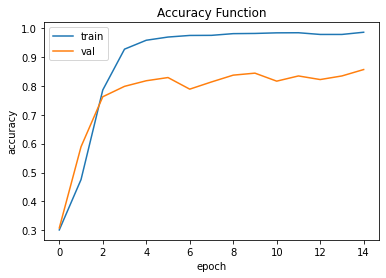

In [73]:
import matplotlib.pyplot as plt

accuracy = procces.history['accuracy']
val_accuracy = procces.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy Function')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

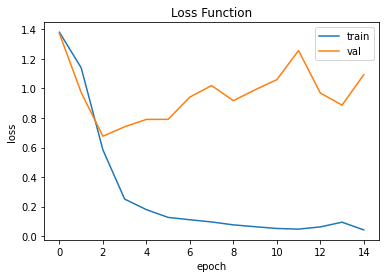

In [74]:
loss = procces.history['loss']
val_loss = procces.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss Function')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()